<a href="https://colab.research.google.com/github/samleonnn/HerAi-Model-Development/blob/main/WasteSegregation_TransferLearning_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ProjectSecret/AllMainData_v3.zip", "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
TRAIN_DIR = "/tmp/AllMainData_v3/TRAIN"
VAL_DIR  = "/tmp/AllMainData_v3/VAL"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                    batch_size=128, 
                                    class_mode="categorical",
                                    target_size=(299, 299))

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.5)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(299, 299),
                                            subset = "training",
                                            shuffle = False)

test_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(299, 299),
                                            subset = "validation",
                                            shuffle = False)

Found 21249 images belonging to 3 classes.
Found 3212 images belonging to 3 classes.
Found 3211 images belonging to 3 classes.


In [ ]:
print(train_generator.class_indices)

{'Non-Recyclable': 0, 'Organic': 1, 'Recyclable': 2}


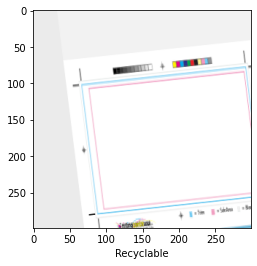

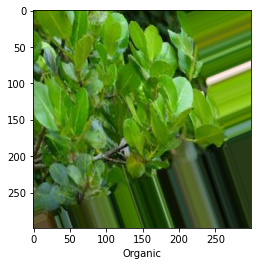

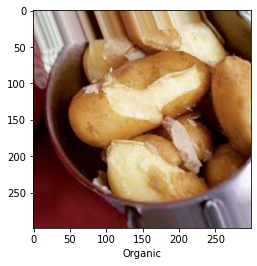

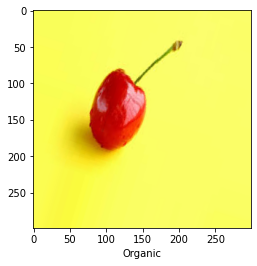

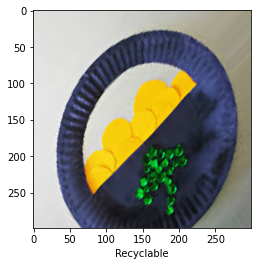

In [ ]:
class_names = ["Non-Recyclable", "Organic", "Recyclable"]
x,y = train_generator.next()

for i in range(5):
    image = x[i]
    label = np.argmax(y[i])
    plt.xlabel(class_names[label])
    plt.imshow(image)
    plt.show()

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(299, 299, 3),
                          pooling='avg')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
last_layer = pre_trained_model.get_layer('block13_sepconv2_act')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 19, 19, 728)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# opt = "adam"
opt = tf.keras.optimizers.Adam(learning_rate = 0.0006)

model.compile(optimizer=opt,
            loss="categorical_crossentropy",
            metrics=['accuracy']) 

In [ ]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = validation_generator)

Epoch 1/10
167/167 [==============================] - 523s 3s/step - loss: 1.1179 - accuracy: 0.7371 - val_loss: 0.3759 - val_accuracy: 0.8362
Epoch 2/10
167/167 [==============================] - 520s 3s/step - loss: 0.3731 - accuracy: 0.8498 - val_loss: 0.3744 - val_accuracy: 0.8412
Epoch 3/10
167/167 [==============================] - 518s 3s/step - loss: 0.3613 - accuracy: 0.8570 - val_loss: 0.3414 - val_accuracy: 0.8639
Epoch 4/10
167/167 [==============================] - 520s 3s/step - loss: 0.3237 - accuracy: 0.8730 - val_loss: 0.3389 - val_accuracy: 0.8646
Epoch 5/10
167/167 [==============================] - 521s 3s/step - loss: 0.3179 - accuracy: 0.8731 - val_loss: 0.3300 - val_accuracy: 0.8611
Epoch 6/10
167/167 [==============================] - 517s 3s/step - loss: 0.2970 - accuracy: 0.8834 - val_loss: 0.3549 - val_accuracy: 0.8590
Epoch 7/10
167/167 [==============================] - 516s 3s/step - loss: 0.2796 - accuracy: 0.8911 - val_loss: 0.3268 - val_accuracy: 0.8733

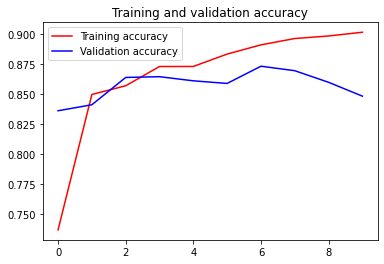

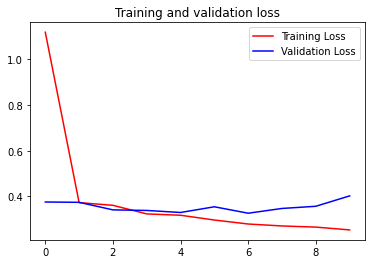

In [ ]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_generator)

26/26 [==============================] - 28s 1s/step - loss: 0.1879 - accuracy: 0.9277


[0.18788833916187286, 0.9277483820915222]

Confusion Matrix


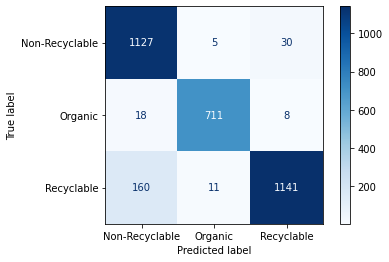


Classification Report
                precision    recall  f1-score   support

Non-Recyclable       0.86      0.97      0.91      1162
       Organic       0.98      0.96      0.97       737
    Recyclable       0.97      0.87      0.92      1312

      accuracy                           0.93      3211
     macro avg       0.94      0.93      0.93      3211
  weighted avg       0.93      0.93      0.93      3211



In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(test_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))   